# Ear Detection and Recognition Evaluation

In [4]:
DETECTION_MODEL_PATH = 'best-fp16.tflite' 
DATASET_PATH = './ami'
IMAGE_SIZE_DETECTION = 640
IMAGE_SIZE = 224

## Load detection model

In [5]:
import numpy as np

In [3]:
import tensorflow as tf
interpreter = tf.lite.Interpreter(model_path=DETECTION_MODEL_PATH)  # load TFLite model
interpreter.allocate_tensors()  # allocate
input_details = interpreter.get_input_details()  # inputs
output_details = interpreter.get_output_details()  # outputs
int8 = input_details[0]['dtype'] == np.uint8  # is TFLite quantized 
print(input_details, output_details)

[{'name': 'input_1', 'index': 0, 'shape': array([  1, 640, 640,   3]), 'shape_signature': array([  1, 640, 640,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] [{'name': 'Identity', 'index': 522, 'shape': array([    1, 25200,     7]), 'shape_signature': array([    1, 25200,     7]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


## Load dataset

In [7]:
from tensorflow import keras
import os

def create_dataset_ami():
  from keras.preprocessing.image import load_img, img_to_array
  import cv2
  img_folder = DATASET_PATH
  img_data_array=[]

  filepaths = os.listdir(img_folder)
  filepaths.sort()
  for f in filepaths:
    if any([f.endswith(x) for x in ['.jpeg', '.jpg', '.png']]):

      image_path=os.path.join(img_folder, f)
      
      image = img_to_array(load_img(image_path))
      
      desired_size = IMAGE_SIZE_DETECTION

      old_size = image.shape[:2] # old_size is in (height, width) format

      ratio = float(desired_size)/max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])

      # new_size should be in (width, height) format

      image = cv2.resize(image, (new_size[1], new_size[0]))

      delta_w = desired_size - new_size[1]
      delta_h = desired_size - new_size[0]
      top, bottom = delta_h//2, delta_h-(delta_h//2)
      left, right = delta_w//2, delta_w-(delta_w//2)

      color = [0, 0, 0]
      new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,
          value=color)
      
      new_im = img_to_array(new_im)

      #new_im = np.dot(new_im[...,:3], [0.299, 0.587, 0.114])
  
      img_data_array.append(new_im)
  
  labels = [[x]*7 for x in range(100)]
  labels = np.array(labels)

  return np.array(img_data_array), labels.flatten()

In [5]:
dataset, labels = create_dataset_ami()

## Detection

In [6]:
def predict(interpreter, data, in_details, out_details):
  from yolov5.utils.torch_utils import select_device
  from yolov5.utils.general import non_max_suppression
  import torch

  device = select_device('')
  imgsz = (IMAGE_SIZE_DETECTION, IMAGE_SIZE_DETECTION)

  preds = []

  for img in data:
    img = torch.from_numpy(img).to(device)
    img = img / 255.0  # 0 - 255 to 0.0 - 1.0
    if len(img.shape) == 3:
            img = img[None]  # expand for batch dim

    imn = img  # image in numpy

    if int8:
                    scale, zero_point = in_details[0]['quantization']
                    imn = (imn / scale + zero_point).astype(np.uint8)  # de-scale
    interpreter.set_tensor(in_details[0]['index'], imn)
    interpreter.invoke()
    pred = interpreter.get_tensor(out_details[0]['index'])

    pred[..., 0] *= imgsz[1]  # x
    pred[..., 1] *= imgsz[0]  # y
    pred[..., 2] *= imgsz[1]  # w
    pred[..., 3] *= imgsz[0]  # h
    pred = torch.tensor(pred)

    # NMS
    pred = non_max_suppression(pred, 0.25, 0.45, 2, False, max_det=1)

    preds.append(pred)
  return preds

In [7]:
preds = predict(interpreter, dataset, input_details, output_details)

In [8]:
# Process predictions
def process_output(dataset, preds, crop=True):
  from yolov5.utils.plots import Annotator, colors
  from yolov5.utils.general import scale_coords, save_one_box
  import torch

  index = 0
  for img, pred in zip(dataset, preds):  # per image
    det = pred[0]
    gn = torch.tensor(img.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    imc = img.copy() if crop else img  # for cropping
    names='earLeft, earRight'
    annotator = Annotator(img, line_width=3, example=names)
    if len(det):
      # Rescale boxes from img_size to im0 size
      det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img.shape).round()

      # Write results
      for *xyxy, conf, cls in reversed(det):
        dataset[index] = save_one_box(xyxy, imc, file=str(index)+'.jpg', save=False)
    index += 1
  return dataset

In [9]:
cropped_dataset = process_output(dataset, preds)

In [10]:
cropped_dataset.shape

(700, 640, 640, 3)

In [12]:
def save_cropped_dataset(dataset, labels):
  import cv2
  i = 0
  for imn, label in zip(dataset, labels):
    bgr = cv2.cvtColor(imn, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'cropped_dataset/{label}_{i}.jpg', bgr)
    i+=1

In [18]:
save_cropped_dataset(cropped_dataset, labels)

In [19]:
cropped_dataset = []

In [3]:
def get_resized_dataset():
  from tensorflow import keras
  from keras.preprocessing.image import img_to_array, load_img
  import cv2

  resized_images = []
  img_folder = './cropped_dataset'
  filepaths = os.listdir(img_folder)
  filepaths.sort()
  for f in filepaths:
    if any([f.endswith(x) for x in ['.jpeg', '.jpg', '.png']]):

      image_path=os.path.join(img_folder, f)
      
      image = img_to_array(load_img(image_path))
      desired_size = IMAGE_SIZE

      old_size = image.shape[:2] # old_size is in (height, width) format

      ratio = float(desired_size)/max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])

      # new_size should be in (width, height) format

      image = cv2.resize(image, (new_size[1], new_size[0]))

      delta_w = desired_size - new_size[1]
      delta_h = desired_size - new_size[0]
      top, bottom = delta_h//2, delta_h-(delta_h//2)
      left, right = delta_w//2, delta_w-(delta_w//2)

      color = [0, 0, 0]
      new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,
          value=color)
      
      resized_images.append(img_to_array(new_im))
  return np.array(resized_images)

In [11]:
cropped_dataset = []

In [6]:
cropped_dataset = get_resized_dataset()

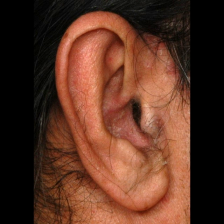

In [7]:
from keras.preprocessing.image import array_to_img
array_to_img(cropped_dataset[34])

## Recognition

In [11]:
class MobileRecognitionModel():
  def __init__(self):
    from tensorflow import keras
    self.model = keras.models.load_model('model_256.h5')  # model
    self.model.summary()
  
  def predict(self, dataset):
    return self.model.predict(dataset)

In [12]:
feature_extractor = MobileRecognitionModel()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 1280)             4226432   
 l)                                                              
                                                                 
 batch_normalization_4 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
Total params: 4,559,488
Trainable params: 0
Non-trainable p

In [13]:
extracted_features = feature_extractor.predict(cropped_dataset)

## Evaluation

In [14]:
def calc_dist_matrix(features, dist_function='correlation'):
  from scipy.spatial.distance import cdist
  dist_matrix = cdist(features, features, metric=dist_function)
  #df = pd.DataFrame(dist_matrix)
  '''
  df.loc[-1] = np.array([[x,] * 7 for x in range(0, 100)]).flatten()  # adding a row
  df.index = df.index + 1  # shifting index
  df.sort_index(inplace=True) 
  '''
  return dist_matrix

In [27]:
distance_matrix_corr = calc_dist_matrix(extracted_features, 'correlation')
distance_matrix_cos = calc_dist_matrix(extracted_features, 'cosine')
distance_matrix_corr.shape, distance_matrix_cos.shape

((700, 700), (700, 700))

In [16]:
def calc_confusion_matrix(threshold, dist_matrix, n_identities=100, n_templates=7):
  conf_matrix = np.zeros((2,2)) #[[ GA FR ]
                                # [ FA GR ]]
  nrows = dist_matrix.shape[0]
  ids = range(0, n_identities)
  for row in range(nrows):
    for id in ids:
      elems = np.arange(id * n_templates, (id + 1) * n_templates)
      m_label = dist_matrix[row, elems[np.where(elems!=row)]]
      if(m_label.min() < threshold):
        if(id == row//n_templates):
          conf_matrix[0,0] += 1       # GA
        else: 
          conf_matrix[1,0] += 1   # FA
      elif(id == row//n_templates):  
        conf_matrix[0,1] += 1         # FR
      else:
        conf_matrix[1,1] += 1         # GR
  
  return conf_matrix

conf_matrix_corr = calc_confusion_matrix(0.4, distance_matrix_corr[:,:], n_identities=100)
conf_matrix_cos = calc_confusion_matrix(0.4, distance_matrix_cos[:,:], n_identities=100)

array([[6.9900e+02, 1.0000e+00],
       [4.8797e+04, 2.0503e+04]])

In [17]:
def get_genuine_impostor_scores(dist_matrix, n_identities=100, n_templates=7):
  genuine_scores = []
  impostor_scores = []
  nrows = dist_matrix.shape[0]
  for row in range(nrows):
    for id in range(n_identities):
      elems = np.arange(id * n_templates, (id + 1) * n_templates)
      m_label = dist_matrix[row, elems[np.where(elems!=row)]]
      if(id == row//n_templates): # genuine
        genuine_scores.append(m_label)
      else:                       # impostor
        impostor_scores.append(m_label)

  return np.array(genuine_scores).flatten(), np.array(impostor_scores).flatten()

In [28]:
genuine_scores_corr, impostor_scores_corr = get_genuine_impostor_scores(distance_matrix_corr)
genuine_scores_corr.shape, impostor_scores_corr.shape

((4200,), (485100,))

In [29]:
genuine_scores_cos, impostor_scores_cos = get_genuine_impostor_scores(distance_matrix_cos)
genuine_scores_cos.shape, impostor_scores_cos.shape

((4200,), (485100,))

In [44]:
from pyeer.eer_info import get_eer_stats
stats_corr = get_eer_stats(genuine_scores_corr, impostor_scores_corr, ds_scores=True)

In [45]:
stats_cos = get_eer_stats(genuine_scores_cos, impostor_scores_cos,ds_scores=True)

In [36]:
from pyeer.plot import plot_eer_stats
from matplotlib import pyplot as plt
plot_eer_stats([stats_corr, stats_cos], ['FE_256_corr', 'FE_256_cos'], save_plots=True, lgf_size=10, dpi=1000, bins=200, save_path='./scores/', ext='.jpg')

In [37]:
def get_stats(dist_matrix, n_identities=100, n_templates=7):
  n_rows = dist_matrix.shape[0]
  n_cols = dist_matrix.shape[1]
  stats=np.empty((n_rows, n_cols-1, 3))
  for row in range(n_rows):
    for col in range(n_cols):
        if(row!=col):
          dist = dist_matrix[row, col]
          
          i = row
          j = col
          
          if(j>=i):
            j -= 1

          stats[i,j,0] = row
          stats[i,j,1] = col
          stats[i, j, 2] = dist

  return stats.reshape(-1, 3)

In [38]:
def get_tp(dist_matrix, n_templates=7, n_classes=100):
  n_rows = dist_matrix.shape[0]
  tp = np.empty((n_rows, 2))

  for row in range(n_rows):
    tp[row, 0] = row
    id = row // n_templates
    elems = np.arange(id * n_templates, (id + 1) * n_templates)

    gen_templ_dists = dist_matrix[row, elems]
    
    gen_templ_min_dist = np.inf
    dist_min = gen_templ_dists.min()  # the min will be ~zero, since it's the
                                      # distance from the same vector
    argmin = 0
    
    for i, dist in enumerate(gen_templ_dists): # search second minimum
      if(dist != dist_min and dist < gen_templ_min_dist):
        gen_templ_min_dist = dist
        argmin = i
    
    tp[row, 1] = id * n_templates + argmin
  return tp

In [23]:
tp_corr = get_tp(distance_matrix_corr)
stats_corr = get_stats(distance_matrix_corr)
stats_corr.shape, tp_corr.shape

((489300, 3), (700, 2))

In [40]:
tp_cos = get_tp(distance_matrix_cos)
stats_cos = get_stats(distance_matrix_cos)
stats_cos.shape, tp_cos.shape

((489300, 3), (700, 2))

In [41]:
def calc_scores(stats, tp, ds_scores=True):
  import operator

  SCORE_POS = 1
  TEMPLATE_POS = 0

  matching_scores = {}
  for row in tp:
    query, template = row
    if query in matching_scores:
      matching_scores[query][TEMPLATE_POS].append(template)
    else:
      matching_scores[query] = ([template], [])
  
  for row in stats:
    query, template, score = row
    matching_scores[query][SCORE_POS].append((template, score))

  for query_match_info in matching_scores.values():
        query_match_info[SCORE_POS].sort(key=operator.itemgetter(1),
                                        reverse=not ds_scores)
  return matching_scores

In [42]:
from pyeer.cmc_stats import get_cmc_curve, CMCstats
from pyeer.plot import plot_cmc_stats

scores_corr = calc_scores(stats_corr, tp_corr)
scores_cos = calc_scores(stats_cos, tp_cos)

In [43]:
r=20

# Calculating CMC curve
ranks_corr = get_cmc_curve(scores_corr, r)
ranks_cos = get_cmc_curve(scores_cos, r)

# Creating stats
stats = [CMCstats(exp_id='FE_256_corr', ranks=ranks_corr), CMCstats(exp_id='FE_256_cos', ranks=ranks_cos)]

# Plotting
plot_cmc_stats(stats, r, save_plots=True, lgf_size=10, dpi=1000, save_path='./scores/', ext='.jpg')